In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
from randaugment import RandAugmentMC

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9 
LAMBDA_U = 3
MU = 4 # Coefficient for scaling the unlabeled loss
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [6]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

In [7]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]
Files already downloaded and verified


In [8]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## IV. Semi-Supervised Learning: Fixmatch - Data Alignment

### IV.1 Fixmatch on 10% train data - Data Alignment

In [9]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.10
CIFAR10_class_distribution = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    RandAugmentMC(n=2, m=10),
    transforms.Normalize(mean, std)
])
    

In [11]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [12]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 20.51%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 32.45%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 37.56%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.35%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 38.64%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 44.95%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 43.41%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 49.84%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 49.45%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.04%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.41%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.11%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.78%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.63%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.21%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.19%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.37%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.91%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.05%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.16%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.6%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.56%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.73%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.99%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.5%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.07%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.4%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.56%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.37%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.88%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.12%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.76%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.6%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.68%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.9%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.66%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.91%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.86%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.49%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.76%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.06%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.11%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.16%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.21%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.08%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.09%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.46%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.43%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.52%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.26%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.71%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.36%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.6%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.07%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.75%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.08%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.6%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.1%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.86%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.35%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.5%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.64%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.25%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.3%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.49%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.68%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.4%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.06%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.37%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.35%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.97%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.37%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.57%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.43%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.38%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.28%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.74%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.64%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.43%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.87%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.99%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.32%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.22%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.43%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.88%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.37%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.38%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.15%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.64%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.32%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.13%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.81%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.63%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.37%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.7%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.43%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.75%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.21%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.19%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.69%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.8%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.95%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.42%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.92%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.81%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.24%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.42%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.83%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.04%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.32%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.55%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.32%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.48%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.31%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.59%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.6%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.35%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.81%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.27%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.47%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.47%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.01%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.05%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.76%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.54%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.91%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.78%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.15%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.79%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.42%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.06%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.08%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.66%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.98%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.03%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.0%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.36%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.46%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.67%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.65%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.72%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.25%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.95%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.68%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.77%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.34%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.36%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.35%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.2%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.28%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.7%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.49%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.39%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.16%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.14%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.24%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.74%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.43%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.73%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.25%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.47%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.59%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.5%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.44%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.31%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.15%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.03%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.3%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.85%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.98%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.07%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.65%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.84%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.92%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.22%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.92%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.03%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.77%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.42%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.35%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.52%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.79%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.16%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.89%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.02%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.62%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.95%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.85%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.35%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.65%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.9%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.41%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.37%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.34%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.75%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.58%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.02%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.89%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.76%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.72%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.34%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.97%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.03%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.04%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.18%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.24%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.85%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.09%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.37%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.17%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.27%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.65%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.93%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.96%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.77%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.64%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.36%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.96%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.74%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.72%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.5%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.47%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.64%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.55%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.64%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.38%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.81%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.78%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.83%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.48%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.74%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.79%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.87%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.72%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.25%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.98%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.05%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.0%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.98%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.23%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.12%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.34%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.03%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.01%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.38%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.3%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.24%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.49%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.32%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.38%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.51%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.49%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.46%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.37%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.33%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.5%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.24%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.36%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.62%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.58%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.52%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.5%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.55%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.49%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.56%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.53%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.52%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.62%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.57%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.65%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.66%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.64%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.66%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.67%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.7%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.7%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.69%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 82.69%


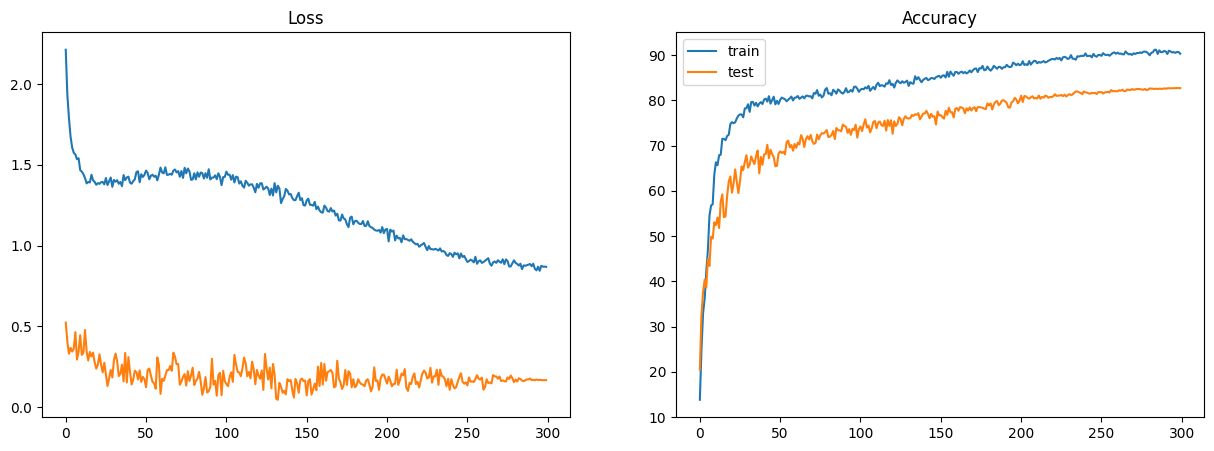

In [13]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_DA_10_losses_accuracies.png")

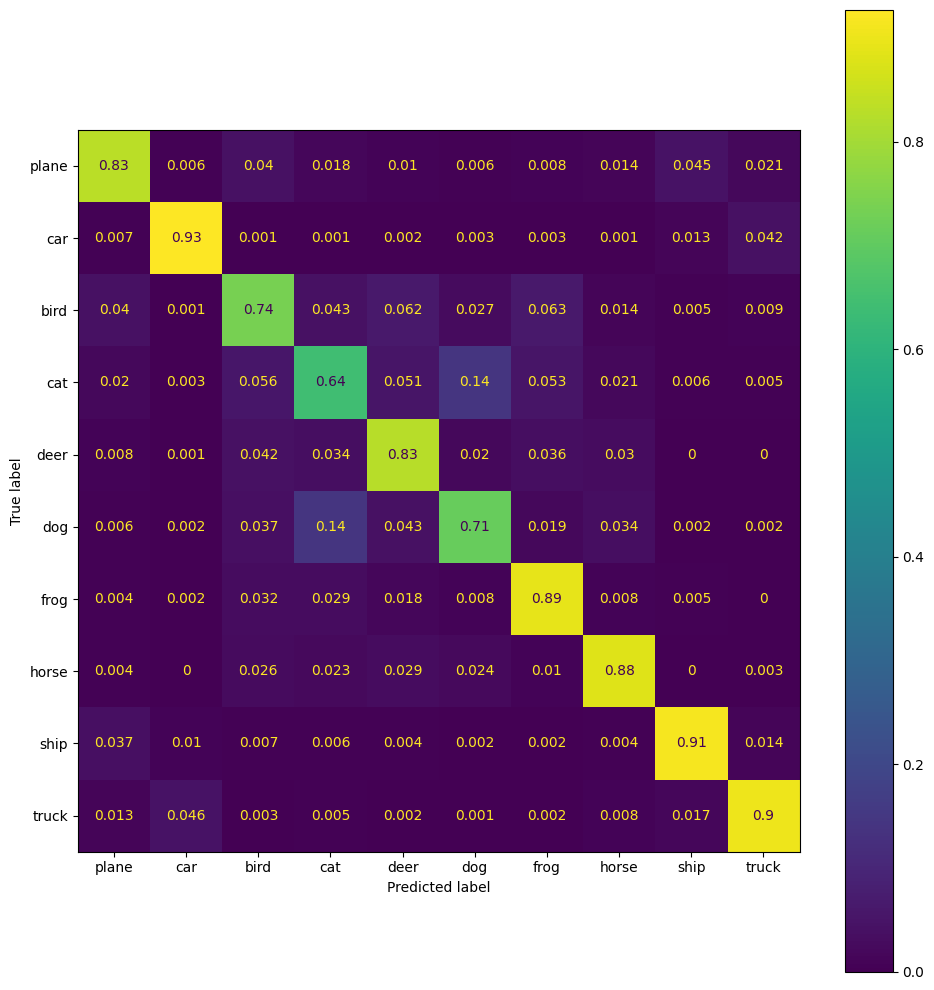

In [14]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_DA_10_confusion_matrix.png")

Test Accuracy: 82.69%


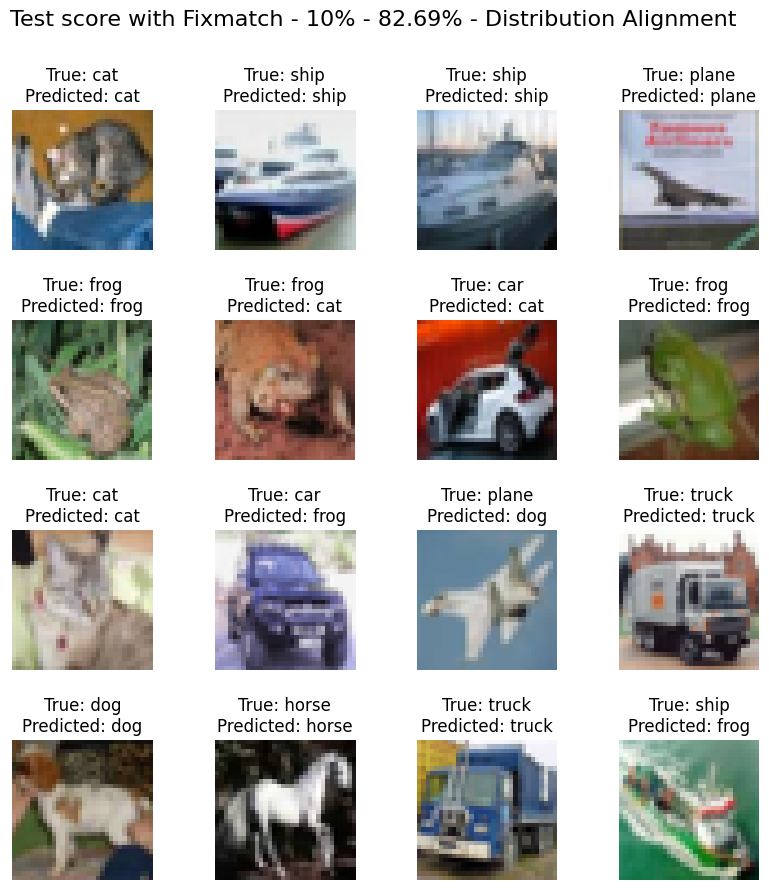

In [15]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Distribution Alignment")
fig1.savefig(f"./figures/test_score_10_fixmatch_DA.png")

### IV.2 Fixmatch on 5% train data - Data Alignment

In [16]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 200
SUBSET_PROP = 0.05
CIFAR10_class_distribution = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [17]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        # moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.21%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.73%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 16.84%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 33.46%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 26.66%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.36%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.85%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 38.57%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.18%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.71%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.95%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.04%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.32%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.02%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 41.97%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.24%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.39%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.61%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.73%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.45%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.82%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.79%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.15%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.04%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.18%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.52%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.23%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.75%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.98%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.98%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.11%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.8%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.56%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.59%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.24%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.41%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.28%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.8%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.92%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.58%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.78%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.26%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.35%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.49%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.1%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.53%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.47%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.02%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.35%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.29%


Epoch    50:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.99%


Epoch    51:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.0%


Epoch    52:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.95%


Epoch    53:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.75%


Epoch    54:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.14%


Epoch    55:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.46%


Epoch    56:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.85%


Epoch    57:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.69%


Epoch    58:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.28%


Epoch    59:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.74%


Epoch    60:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.91%


Epoch    61:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.37%


Epoch    62:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.09%


Epoch    63:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.21%


Epoch    64:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.59%


Epoch    65:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.73%


Epoch    66:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.94%


Epoch    67:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.31%


Epoch    68:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.84%


Epoch    69:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.59%


Epoch    70:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.53%


Epoch    71:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.6%


Epoch    72:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.69%


Epoch    73:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.54%


Epoch    74:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.66%


Epoch    75:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.25%


Epoch    76:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.72%


Epoch    77:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.43%


Epoch    78:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.41%


Epoch    79:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.03%


Epoch    80:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.7%


Epoch    81:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.01%


Epoch    82:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.61%


Epoch    83:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.08%


Epoch    84:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.09%


Epoch    85:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.32%


Epoch    86:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.98%


Epoch    87:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.41%


Epoch    88:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.5%


Epoch    89:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.1%


Epoch    90:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.67%


Epoch    91:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.33%


Epoch    92:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.32%


Epoch    93:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.65%


Epoch    94:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.36%


Epoch    95:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.19%


Epoch    96:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.18%


Epoch    97:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.65%


Epoch    98:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.96%


Epoch    99:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.59%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.88%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.76%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.14%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.35%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.77%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.57%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.31%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.71%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.47%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.78%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.86%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.66%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.28%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.37%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.35%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.62%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.63%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.96%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.88%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.1%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.26%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.15%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.15%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.13%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.96%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.11%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.85%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.85%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.19%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.25%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.47%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.99%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.66%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.39%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.29%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.97%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.65%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.4%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.68%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.2%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.45%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.02%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.98%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.08%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.69%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.8%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.7%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.02%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.69%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.53%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.62%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.06%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.04%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.69%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.3%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.25%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.17%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.14%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.63%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.49%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.47%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.78%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.82%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.76%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.72%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.69%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.09%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.15%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.05%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.15%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.93%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.45%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 75.98%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.23%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.22%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.31%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.35%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.23%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.06%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.04%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.06%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.21%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.25%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.29%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.4%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.43%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.42%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.46%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.52%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.5%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.47%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 76.48%


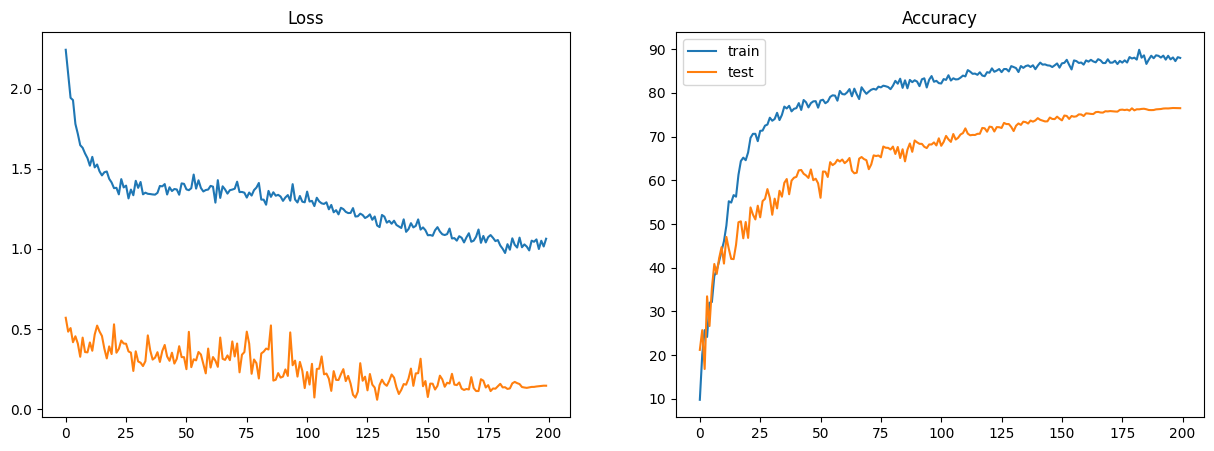

In [18]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_DA_5_losses_accuracies.png")

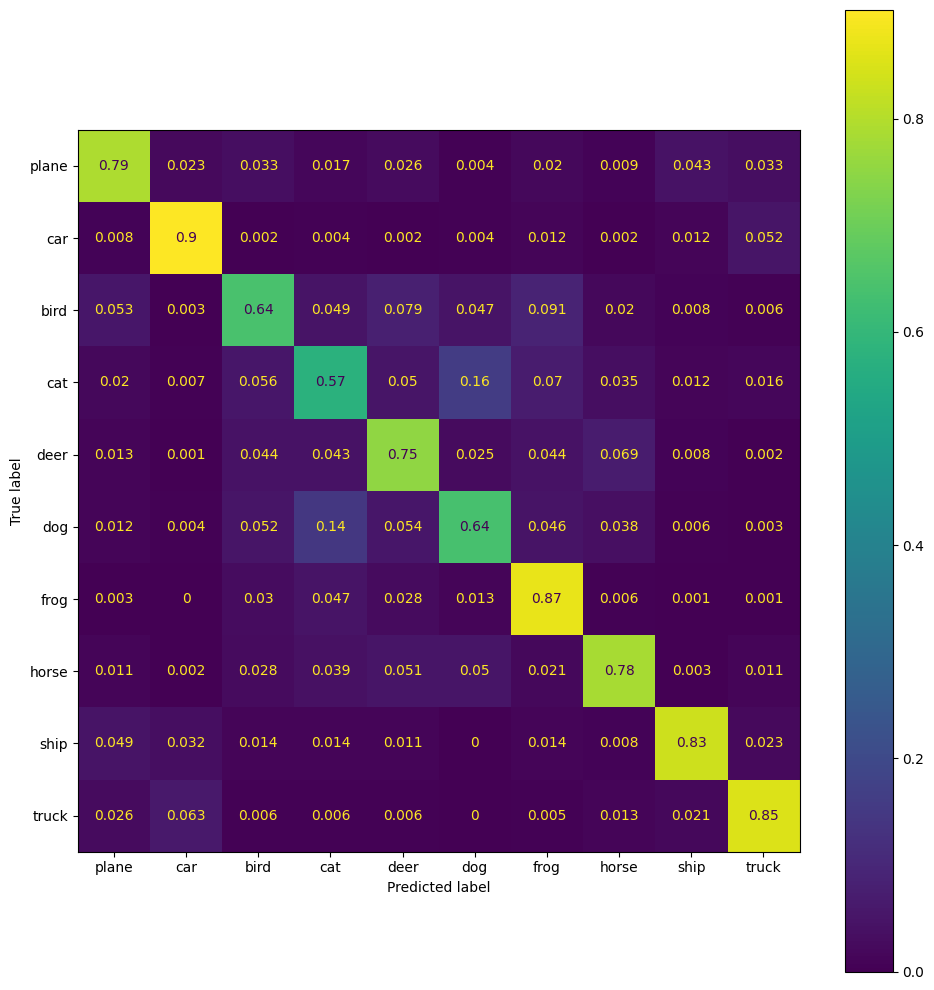

In [19]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_DA_5_confusion_matrix.png")

Test Accuracy: 76.48%


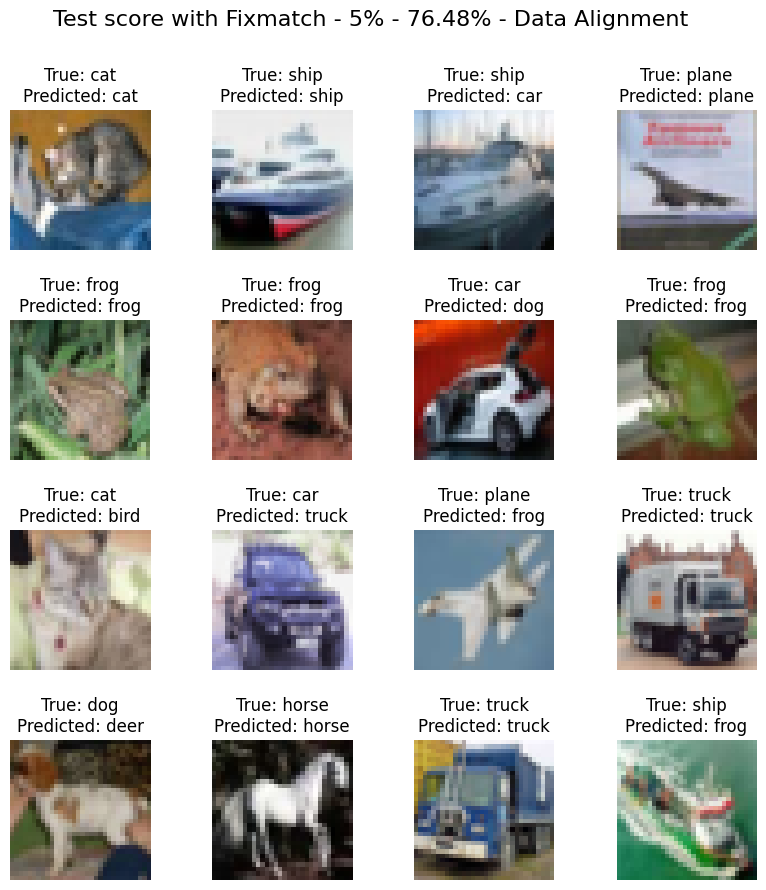

In [20]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_5_fixmatch_DA.png")

### IV.3 Fixmatch on 1% train data - Data Alignment

In [21]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 300
SUBSET_PROP = 0.01
CIFAR10_class_distribution = 0.10 

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [22]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        # moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.13%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 14.96%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 20.26%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 18.56%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.13%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.85%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.64%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 24.49%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.74%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.48%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.97%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.29%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.8%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.24%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.15%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.24%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.71%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.2%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.82%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.32%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.13%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.65%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.94%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.56%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.89%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.19%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.24%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.37%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.82%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.49%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.25%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.66%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.94%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.73%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.84%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.58%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.37%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.22%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.57%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.66%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.35%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.84%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.85%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.92%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.52%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.29%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.94%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.53%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.36%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.52%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.65%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.0%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.49%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.6%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.94%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.22%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.72%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.1%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.65%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.28%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.31%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.6%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.42%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.87%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.93%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.07%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.22%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.92%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.89%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.35%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.3%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.93%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.44%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.89%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.85%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.69%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.13%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.62%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.73%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.22%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.62%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.82%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.59%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.52%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.9%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.22%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.36%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.42%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.84%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.35%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.19%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.44%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.98%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.05%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.95%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.64%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.16%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.48%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.51%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.91%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.58%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.0%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.53%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.82%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.96%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.1%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.55%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.23%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.48%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.96%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.64%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.14%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.25%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.67%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.41%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.24%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.39%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.72%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.38%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.57%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.87%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.4%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.72%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.48%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.38%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.41%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.73%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.77%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.33%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.84%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.68%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.97%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.08%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.18%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.63%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.09%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.57%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.09%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.18%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.33%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.05%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.77%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.99%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.41%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.18%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.92%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.72%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.28%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.69%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.24%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.54%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.78%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.21%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.99%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.12%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.13%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.22%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.8%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.45%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.06%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.46%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.45%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.16%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.67%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.87%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.76%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.92%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.47%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.76%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.75%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.29%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.05%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.84%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.83%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.05%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.19%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.13%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.65%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.98%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.68%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.59%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.03%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.99%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.36%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.9%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.95%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.95%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.4%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.72%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.61%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.34%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.43%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.14%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.32%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.77%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.95%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.69%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.81%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.7%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.3%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.12%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.26%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.9%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.0%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.67%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.49%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.17%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.57%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.6%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.95%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.19%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.68%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.9%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.68%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.71%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.07%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.54%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.95%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.65%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.73%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.93%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.93%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.23%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.84%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.71%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.91%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.99%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.63%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.44%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.56%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.42%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.57%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.1%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.75%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.33%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.61%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.16%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 49.89%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.41%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.74%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.84%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.88%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.52%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.53%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.71%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.55%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.54%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.75%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.99%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.99%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.62%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 50.72%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.15%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.39%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.64%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.58%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.75%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.47%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.58%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.65%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.88%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.71%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.9%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.89%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.8%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.85%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.62%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.61%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.78%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.67%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.66%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.73%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.79%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.85%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.94%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.96%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.83%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.82%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.83%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.82%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.8%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.82%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.69%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.72%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.77%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.89%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.87%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.89%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.82%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.8%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.82%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.88%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.87%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 51.86%


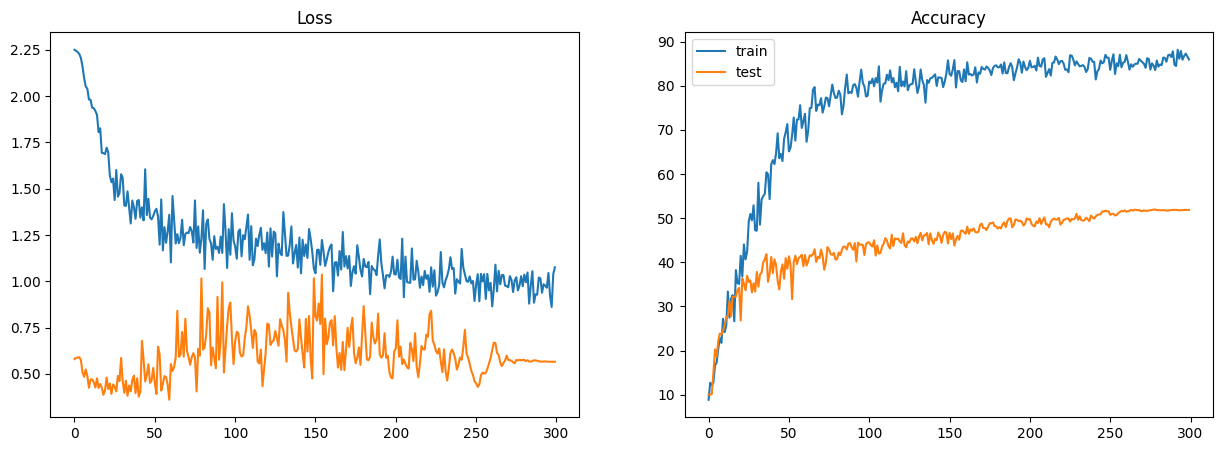

In [23]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"figures/unsup_DA_1_losses_accuracies.png")

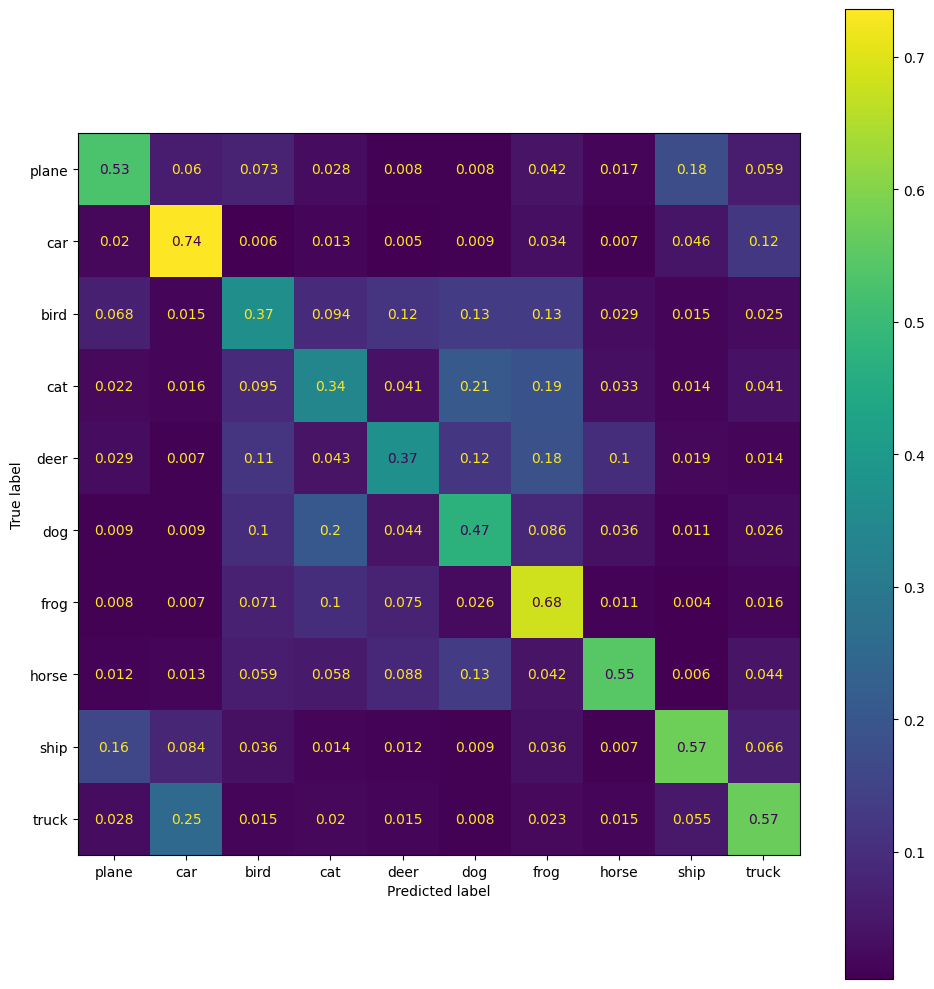

In [24]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/unsup_DA_1_confusion_matrix.png")

Test Accuracy: 51.86%


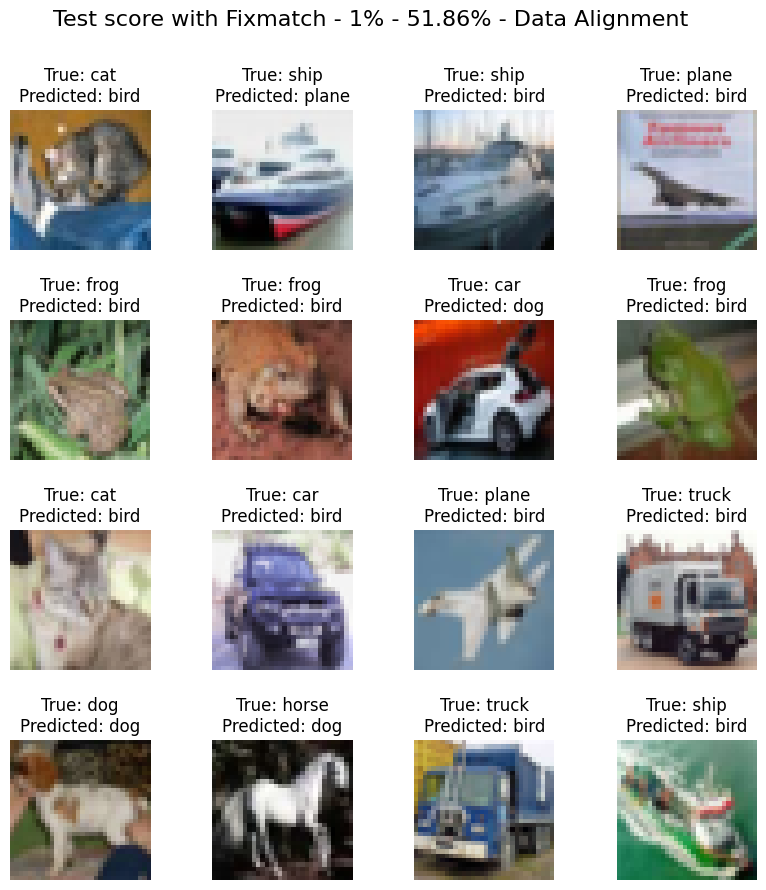

In [25]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_1_fixmatch_DA.png")